# Insights from Death Row in Texas

In this project, we will explore Death Row data in the State of Texas. The dataset contains information on executions from 1982 to present, including details about the prisoners on death row. The goal is to draw insights from the data which will help us better understand Death Row overall and the prisoners who've lived there. Some topics covered in this project:
* Analysis of death row prisoner demographic factors (race, location, age, education level)
  - Gender will not be included as this data point was missing for over 60% of the prisoners
* How Death Row has changed over the years
* Text Analysis on inmate's Last Statement before execution

The death penalty is currently authorized in 27 states, the federal government, and the U.S. military. Texas leads the nation in the number of executions since the death penalty was reinstated in 1976. The State of Texas adopted lethal injection as means of execution in 1977 and executed the first inmate by lethal injection on December 7, 1982 (this is the starting point of the data we use in this project).

The data used in this project was scraped from the official website of the Texas Department of Criminal Justice (TDCJ): https://www.tdcj.texas.gov/

In [1]:
import pandas as pd
import numpy as np
import requests
import urllib.request
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from pytesseract import pytesseract
import re
from matplotlib import pyplot as plt
import datetime as dt
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams

In [2]:
%%html
<style> table {float:left} </style>

## Collecting Data
To start, we will be scraping the TDCJ's website using the Python library BeautifulSoup.The specific web page we will be starting with can be found: [here]('https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html'). It contains a table with information about inmates who have been executed between <code>12/07/1982</code> and <code>2/5/2023</code>. In the next cell, we:
* Extract the HTML from the the webpage into a python object
* Parse the object to make it more accessible
* Locate the table element and save it as a variable
* Extract and clean the text from each table row, convert the row into a list, and append it to a list of lists
* Convert the list of lists into a pandas dataframe

In [3]:
# URL of target webpage
URL = 'https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html'
# Extract HTML from webpage
page = requests.get(URL, verify=False)
# Parse HTML
soup = BeautifulSoup(page.content, "html.parser")
# Save table element in variable
results = soup.find('table')
# Convert table element into list of lists
table_rows = []
for child in results.children:
    if child.text != '\n':
        table_rows.append(child.text
                               .strip()
                               .replace('\n','*')
                               .split('*')
                         )
    
death_row = pd.DataFrame(table_rows[2:], columns=table_rows[1])
death_row

,Execution,Link,Link,Last Name,First Name,TDCJNumber,Age,Date,Race,County
0,580,Inmate Information,Last Statement,Ruiz,Wesley,999536,43,2/1/2023,Hispanic,Dallas
1,579,Inmate Information,Last Statement,Fratta,Robert,999189,65,1/10/2023,White,Harris
2,578,Inmate Information,Last Statement,Barbee,Stephen,999507,55,11/16/2022,White,Tarrant
3,577,Inmate Information,Last Statement,Beatty,Tracy,999484,61,11/9/2022,White,Smith
4,576,Inmate Information,Last Statement,Ramirez,John,999544,38,10/5/2022,Hispanic,Nueces
...,...,...,...,...,...,...,...,...,...,...
575,5,Inmate Information,Last Statement,Skillern,Doyle,518,49,01/16/1985,White,Lubbock
576,4,Inmate Information,Last Statement,Barefoot,Thomas,621,39,10/30/1984,White,Bell
577,3,Inmate Information,Last Statement,O'Bryan,Ronald,529,39,03/31/1984,White,Harris
578,2,Inmate Information,Last Statement,Autry,James,670,29,03/14/1984,White,Jefferson


In [4]:
death_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Execution   580 non-null    object
 1   Link        580 non-null    object
 2   Link        580 non-null    object
 3   Last Name   580 non-null    object
 4   First Name  580 non-null    object
 5   TDCJNumber  580 non-null    object
 6   Age         580 non-null    object
 7   Date        580 non-null    object
 8   Race        580 non-null    object
 9   County      580 non-null    object
dtypes: object(10)
memory usage: 45.4+ KB


#### Renaming Columns and Updating Data Types

In [5]:
# Rename columns
death_row.columns = ['execution', 
                     'inmate_info_link', 
                     'last_statement_link',
                     'last_name',
                     'first_name',
                     'TDCJNumber',
                     'age_executed',
                     'execution_date',
                     'race',
                     'county'
                    ]
# Updating data types
death_row['execution'] = death_row['execution'].astype('int')
death_row['age_executed'] = death_row['age_executed'].astype('int')
death_row['execution_date'] = pd.to_datetime(death_row['execution_date'], format='%m/%d/%Y')
# Create column for execution year
death_row['execution_year'] = death_row['execution_date'].dt.year

## Extracting URLs for Last Statement and Inmate Information
In the dataframe above, we can see two columns called <code>Link</code> (renamed: <code>inmate_info_link</code> and <code>last_statement_link</code>). The two columns are supposed to link to other webpages - one that contains additional information about the inmate and the other has the inmates final statement before being executed. The links were not included when we converted the original table to the dataframe, so we want to add them to these columns.  

After inspecting the HTML of the page, we confirmed that the URLs can be found in <code>&lt;a&gt;</code> tags. We can retrieve the correct URLs by searching all <code>&lt;a&gt;</code> tags for a specific text string. For example, "inmate information" or "last statement". Let's check to see if our search strings return the desired results. 

In [6]:
# Counting number of inmate information URLs found 
print(len(results.find_all('a', string=lambda text: 'inmate information' in text.lower())))
# Counting number of last statement URLs found 
print(len(results.find_all('a', string=lambda text: 'last statement' in text.lower())))

580
577


We are getting 580 URLs for "inmate information" but only 577 for "last statement". We'll do some additional filtering to try to find the 3 missing last statement links. 

In [7]:
# Create filter to exclude the URLs already identified in the previous cell
mask = lambda text: ('inmate information' not in text.lower()) and ('last statement' not in text.lower())
# Search <a> tags for the 3 missing URLs
results.find_all('a', string=mask)

[<a href="dr_info/wrightgregorylast.html" title="Last Statement of Gregory Wright">Last Statemen</a>,
 <a href="dr_info/wattskevinlast.html" title="Last Statement of Kevin Watts">Last Statemen</a>,
 <a href="dr_info/no_last_statement.html" title="Last Statement of Michael Griffith">Last Statemen</a>]

Above we can see that the 3 URLs were not returned because they are missing a "t" at the end of "statement". We'll use "last statemen" as our search string going forward to account for these. 

In the next cell, we create a function that will:
* Take in a string used to search for the <code>&lt;a&gt;</code> tags with that text
* Extract the path (URL) from from the tag
* Complete the URL by appending the base of the URL to the path
* Return a list of URLs

We'll use this function to update the <code>inmate_info_link</code> and <code>last_statement_link</code> columns with the actual URLs.

In [8]:
def complete_url(search_string):
    urls = []
    # loop through all <a> tags that contain the search_string
    for a in results.find_all('a', string=lambda text: search_string in text.lower()):
        # extract the path from the tag
        link = a['href']
        # append base of the URL to the path
        if 'death_row' in link:
            url = 'https://www.tdcj.texas.gov/' + link
        else:
            url = 'https://www.tdcj.texas.gov/death_row/' + link
        # add url to list
        urls.append(url)

    return urls

# create list of inmate info urls
inmate_info_urls = complete_url('inmate information')
# create list of last statement urls
last_statement_urls = complete_url('last statemen')

# update columns with url lists
death_row['inmate_info_link'] = inmate_info_urls
death_row['last_statement_link'] = last_statement_urls
death_row.head()

,execution,inmate_info_link,last_statement_link,last_name,first_name,TDCJNumber,age_executed,execution_date,race,county,execution_year
0,580,https://www.tdcj.texas.gov/death_row/dr_info/r...,https://www.tdcj.texas.gov/death_row/dr_info/r...,Ruiz,Wesley,999536,43,2023-02-01,Hispanic,Dallas,2023
1,579,https://www.tdcj.texas.gov/death_row/dr_info/f...,https://www.tdcj.texas.gov/death_row/dr_info/f...,Fratta,Robert,999189,65,2023-01-10,White,Harris,2023
2,578,https://www.tdcj.texas.gov/death_row/dr_info/b...,https://www.tdcj.texas.gov/death_row/dr_info/b...,Barbee,Stephen,999507,55,2022-11-16,White,Tarrant,2022
3,577,https://www.tdcj.texas.gov/death_row/dr_info/b...,https://www.tdcj.texas.gov/death_row/dr_info/b...,Beatty,Tracy,999484,61,2022-11-09,White,Smith,2022
4,576,https://www.tdcj.texas.gov/death_row/dr_info/r...,https://www.tdcj.texas.gov/death_row/dr_info/r...,Ramirez,John,999544,38,2022-10-05,Hispanic,Nueces,2022


## Scraping Last Statement Web Pages
Now, we have a list of links to the pages that have the final statements of the inmates (example: [link]('https://www.tdcj.texas.gov/death_row/dr_info/barbeestephenlast.html')). We will again use BeautifulSoup to extract the last statements.

Below we loop through the list of the last statement URLs. For each URL we: 
* Extract the HTML to a python object then parse the object
* Find all the <code>&lt;p&gt;</code> tags
* Each page contains several <code>&lt;p&gt;</code> tags that each store different information, but we only want the last statement. The last statement can always be found in the 6th (last) tag. However, some statements are longer and consist of multiple tags. So, for any page with more than 6 tags, we will extract the text from 6th tag and everything after.
* For the inmates that declined to give a last statement we will return "None"
* After we loop through all of the URLs, we'll have a list of last statements which we'll use to create a new column in our dataframe 

In [9]:
last_statements = []
# loop through last statement URLs
for url in last_statement_urls:
    # extract html
    page = requests.get(url, verify=False)
    # parse html
    soup = BeautifulSoup(page.content, "html.parser")
    # find all <p> tags
    p_tags = soup.find_all('p')
    # last statement contained in single <p> tag
    if len(p_tags) == 6:
        statement = (p_tags[5].text
                              .replace('\xa0', '')
                              .replace('\r','')
                              .replace('\n','')
                    )
        last_statements.append(statement)
    # last statement contained in multiple <p> tags
    if len(p_tags) > 6:
        statement = ''
        for p in p_tags[5:]:
            statement += (p.text
                           .replace('\xa0', '')
                           .replace('\r','')
                           .replace('\n','')
                         )
        last_statements.append(statement)
    # no last statment given
    if len(p_tags) < 6:
        statement = 'None'
        last_statements.append(statement)
        
# create new column in dataframe for last statments
death_row['last_statement'] = last_statements
death_row.head()

,execution,inmate_info_link,last_statement_link,last_name,first_name,TDCJNumber,age_executed,execution_date,race,county,execution_year,last_statement
0,580,https://www.tdcj.texas.gov/death_row/dr_info/r...,https://www.tdcj.texas.gov/death_row/dr_info/r...,Ruiz,Wesley,999536,43,2023-02-01,Hispanic,Dallas,2023,I would like to apologize to the Nix family f...
1,579,https://www.tdcj.texas.gov/death_row/dr_info/f...,https://www.tdcj.texas.gov/death_row/dr_info/f...,Fratta,Robert,999189,65,2023-01-10,White,Harris,2023,No last statement given.
2,578,https://www.tdcj.texas.gov/death_row/dr_info/b...,https://www.tdcj.texas.gov/death_row/dr_info/b...,Barbee,Stephen,999507,55,2022-11-16,White,Tarrant,2022,I want to take this moment to be shared with e...
3,577,https://www.tdcj.texas.gov/death_row/dr_info/b...,https://www.tdcj.texas.gov/death_row/dr_info/b...,Beatty,Tracy,999484,61,2022-11-09,White,Smith,2022,"Yes, I just want to thank (pause) I don’t wan..."
4,576,https://www.tdcj.texas.gov/death_row/dr_info/r...,https://www.tdcj.texas.gov/death_row/dr_info/r...,Ramirez,John,999544,38,2022-10-05,Hispanic,Nueces,2022,I just want to say to the family of Pablo Cas...


## Scraping Inmate Information Web Pages
The inmate information web pages have quite a bit of information on them. We are particularly interested in extracting the inmate's <code>Education Level (Highest Grade Completed)</code> and the <code>Age (when Received)</code>, meaning, how old they were when they were put on death row. These pages are not as straight forward as the last statement web pages. For starters, some of the pages are HTML and some are actually JPGs (examples: [html]('https://www.tdcj.texas.gov/death_row/dr_info/barbeestephen.html'), [jpg]('https://www.tdcj.texas.gov/death_row/dr_info/frattarobert.jpg')). Obviously, we will not be able to scrape the JPG pages in the same way we've been doing. Instead, we will create two separate functions to handle the extraction of data from these two types of pages.

The function for the HTML pages (<code>extract_from_html</code>) will follow a similar structure to what we've done previously. Extracting and parsing the HTML, finding the table element, and retrieving the text from the rows by searching for a string using regex. 

For the function that will extract information from the JPG pages (<code>extract_from_img</code>), we'll use a Python library called Pytesseract which can read the text embedded in images. The steps we'll take in the function are:
* Download the image and store it as an image object
* Use the Pytesseract <code>image_to_string</code> function to extract the text from the image
* Use regex to find the years of education and age received from the extracted text
* For cases where <code>Age (when Received)</code> isn't available, we'll try to extract the <code>Date Received</code>

In [10]:
def extract_from_html(inmate_info_url):
    # Extract HTML from web page
    page = requests.get(inmate_info_url, verify=False)
    # Parse HTML
    soup = BeautifulSoup(page.content, "html.parser")
    # Save table element to a variable
    results = soup.find('table')

    # If a table element is found, save all table rows to variable
    if results != None:
        rows = results.find_all('tr')
        # Loop through table rows
        for row in rows: 
            # Check if row text contains "age", "received"  
            if re.findall('age.*received', row.text.lower()):
                # Extract number (age) 
                age_received = re.findall(r'\d+', row.text)
                # Return NA if age is not listed, otherwise return number 
                if len(age_received) == 0:
                    age = 'NA'
                else:
                    age = age_received[0]
            # Check if row text contains "education level" 
            if re.findall('education level', row.text.lower()):
                # Extract number (education level)
                yrs_education = re.findall(r'\d+', row.text)
                # Return NA if education is not listed, otherwise return number
                if len(yrs_education) == 0:
                    yrs_education = 'NA'
                else:
                    yrs_education = yrs_education[0]
                return yrs_education, age
    else:
        # If no table element is found return NA for years education and age received
        return 'NA', 'NA'
    
    
def extract_from_img(image_url):
    # Defining tesseract executable location as a string
    path_to_tesseract = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    # Extracting *.jpg from url to use for the name of the image file
    file_name = re.search('dr_info/(.*)', image_url).group(1)

    # Download image
    urllib.request.urlretrieve(image_url, file_name)
    # Opening the image & storing it in an image object
    img = Image.open(file_name)
    # Providing the tesseract executable location to pytesseract library
    pytesseract.tesseract_cmd = path_to_tesseract

    # Passing the image object to image_to_string() function which will extract the text from the image
    text = pytesseract.image_to_string(img)

    # Extracting highest grade finished from string. Return NA if it cannot be found/is not included
    education_level = re.search('education level(.*)\n', text.lower())
    if education_level == None:
        yrs_education = 'NA'
    else:
        # Extract number (education level)
        education_list = re.findall(r'\d+', education_level.group(1))
        if len(education_list) == 0:
            yrs_education = 'NA'
        else:
            yrs_education = education_list[0]

    # Extracting age received or date received from string
    # Check if row text contains "age:"
    age_received = re.search('age:(.*)\n', text.lower())
    # When age received cannot be found, search for date received
    if age_received == None or len(re.findall(r'\d+', age_received.group(1))) == 0:
        date_received = re.search('received:(.*)\n', text.lower())
        if date_received == None:
            date = 'NA'
        else:
            # Extract date from string
            date_list = re.findall(r'\d+\/\d+ ?\/\d+', date_received.group(1))
            if len(date_list) == 0:
                date = 'NA'
            else:
                date = date_list[0]
        
        return yrs_education, date

    else:
        # Extract number (age) from string
        age_recd_list = re.findall(r'\d+', age_received.group(1))
        age = age_recd_list[0]
            
        return yrs_education, age

Below we test our functions on 3 different URLs to confirm they're working and show the output.

In [11]:
print(extract_from_html('https://www.tdcj.texas.gov/death_row/dr_info/barbeestephen.html'))
print(extract_from_img('https://www.tdcj.texas.gov/death_row/dr_info/frattarobert.jpg'))
print(extract_from_img('https://www.tdcj.texas.gov/death_row/dr_info/rumbaugh.jpg'))

('11', '38')
('14', '39')
('NA', '08/25/76')


Our functions appear to be working as expected. Now, we will loop through our list of Inmate Information URLs, check to see if the path ends in <code>.html</code> or <code>.jpg</code> and feed it to the appropriate function. We will also increment the <code>count</code> variable as we loop through so we can track the <code>index</code> of the URL. We'll use this index to ensure were assigning the correct row values when we add the column to our dataframe. 

Once all pages have been processed, we'll end up with two lists: one for highest grade completed and the other for the age/date when the inmate was received on death row. These will be list of lists with the index and value like so <code>[index, value]</code>. We create separate for loops in separate cells because it was resulting in faster processing times.

In [12]:
inmate_education = []
inmate_received = []
count = 0
for url in inmate_info_urls:
    if '.html' in url:
        edu_years, received = extract_from_html(url)
        inmate_education.append([count, edu_years])
        inmate_received.append([count, received])
    
    count += 1

In [13]:
count = 0
for url in inmate_info_urls:
    if '.jpg' in url:
        edu_years, received = extract_from_img(url)
        inmate_education.append([count, edu_years])
        inmate_received.append([count, received])
    
    count += 1

Below are the first 5 values of each list.

In [14]:
print(inmate_education[:5])
print(inmate_received[:5])

[[0, '11'], [2, '11'], [3, '10'], [4, '12'], [5, '8']]
[[0, '29'], [2, '38'], [3, '43'], [4, '24'], [5, '27']]


Next, we'll use these lists to create new columns in our dataframe: <code>years_of_education</code> & <code>age_received</code>.

In [15]:
death_row['years_of_education'] = pd.Series()
for value in inmate_education:
    index = value[0]
    years = value[1]
    
    death_row['years_of_education'].iloc[index] = years
    
death_row['age_received'] = pd.Series()
for value in inmate_received:
    index = value[0]
    received = value[1]
    
    death_row['age_received'].iloc[index] = received

## Cleaning New Columns

When examining our new columns, there are some discrepancies. These are largely a result of scraping the text from the images. Majority of the results are correct but on occassion there could be an obstruction on the image that blocks the retrieval of the desired data.  

**Years of Education Column**  
First let's take a look at the unique values in the <code>years_of_education</code> column.

In [16]:
# Replace string NA will Null 
death_row.years_of_education.replace('NA', np.NaN, inplace=True)
# Convert column to Integer type
death_row['years_of_education'] = (death_row['years_of_education'].astype(float)
                                                                  .astype('Int64')
                                   )
# Check unique values
(death_row.years_of_education.value_counts(dropna=False)
                             .sort_index()
)

1        13
2         2
3         1
4         1
5         3
6        10
7        27
8        47
9        69
10       71
11       71
12       99
13        6
14       15
15        4
16        5
19        3
20        1
22        2
24        1
29        1
32        1
212       1
<NA>    126
Name: years_of_education, dtype: Int64

Above, we see the unique values in the <code>years_of_education</code> column which represents the highest grade completed by the inmate. We see some values that look like they could be too low 1 to 5 and others that are definitely too high 19 to 212. 16 would represent someone who did 4 years of college. I suppose there could be cases where the inmate pursued a masters/doctorate degree which would add additional years to that.  

When reviewing the JPG pages where <code>years_of_education</code> was between 1 and 5, only results 1 and 2 were off from the actual value. I also reviewed result that was 16+. All of inamtes with 16 were accurate but everything 19 and over was off. See the table below for corrected values:

Original | Correct
-------  | -----
 1   | 10 \| 11
 2   | 11
 19  | 10
 20  | 10
 22  | 12 \| 13
 24  | 14
 29  | 10
 32  | 12
 212 | 12  

In addition to the outliers, there are also quite a few null values. When reviewing the pages, execution 28 and earlier did not record that information. There were several others that did not have any education listed but around half of the null values did have it listed but the value was not picked up.  

In the next cell, we will update the incorrect values in the <code>years_of_education</code> column using a dictionary with the <code>execution</code> number as the key and the correct <code>years_of_education</code> as the value. This was a relatively manual process to get the correct values.

In [17]:
# Create dictionary of records where years_of_education is null - execution_number is the dictionary key 
missing_education = {}
for e in death_row[(death_row.years_of_education.isnull())  & (death_row.execution > 28)]['execution']:
    missing_education[e] = 0
    
# Dictionary with correct years_of_education values
update_education = {574: 14, 449: 8, 429: 9, 425: 11, 415: 11, 408: 11, 378: 8, 376: 12, 369: 9, 366: 8, 365: 11, 359: 9,
                    347: 12, 326: 10, 316: 6, 308: 9, 301: 9, 284: 9, 273: 14, 268: 11, 262: 9, 257: 8, 239: 9, 237: 12,
                    228: 9, 225: 9, 224: 12, 219: 9, 214: 12, 213: 8, 207: 11, 200: 11, 197: 15, 196: 13, 194: 11, 186: 8,
                    183: 9, 179: 10, 178: 10, 176: 11, 171: 14, 167: 3, 164: 12, 163: 8, 157: 10, 150: 10, 135: 12,
                    134: 11, 132: 8, 130: 11, 129: 8, 124: 10, 114: 10, 106: 12, 104: 7, 101: 11, 97: 9, 96: 8, 91: 12,
                    80: 8, 77: 12, 76: 9, 74: 5, 73: 11, 68: 9, 67: 10, 65: 11, 61: 8, 59: 12, 52: 9, 48: 11, 47: 10,
                    38: 10, 37: 8, 34: 9, 32: 12, 31: 7, 438: 10, 421: 11, 393: 10, 343: 12, 338:11, 315: 11, 272: 11, 
                    249: 10, 175: 10, 144: 11, 141: 11, 127: 11, 46: 10, 58: 11, 49: 11, 304: 10, 241: 10, 147: 10, 
                    318: 10, 390: 12, 261: 13, 42: 14, 281: 10, 340: 12, 471: 12}
# Loop through dictionary and update years_of_education column in dataframe
for e in update_education:
    execution = e
    years_education = update_education[execution]
    
    death_row.loc[death_row.execution == execution,'years_of_education'] = years_education

Below we check the unique values of the <code>years_of_education</code> column after making updates to some of the bad data.

In [18]:
death_row.years_of_education.value_counts(dropna=False).sort_index()

3         2
4         1
5         4
6        11
7        29
8        60
9        86
10       91
11       95
12      115
13        8
14       19
15        5
16        5
<NA>     49
Name: years_of_education, dtype: Int64

**Age Received Column**  
Moving on to checking for discrepancies in the <code>age_received</code> column. This column will be made up of both numbers (representing ages) and date received where the age wasn't available. So we know we're going to have to convert the dates to ages. Let's start by taking care of some outliers. There are several inmates with single digit values representing the age that they were received on death row, which is impossible.

In [19]:
death_row[death_row.age_received.apply(lambda x: len(x)== 1)]['age_received']

221    2
254    1
276    4
302    6
306    2
314    3
332    7
337    2
341    4
359    6
380    4
394    2
414    4
456    2
474    2
479    2
495    2
497    2
504    3
523    2
538    4
544    1
546    5
577    3
Name: age_received, dtype: object

Above we see a number of very young ages (single digit). Again, this was an issue with the images. Below we'll update these values in the same way we did before. Create a dictionary with the <code>execution</code> number as the key and the <code>age</code> as the value and use this to update our dataframe.

In [20]:
# Dictionary with correct age_received values
update_received = {359:'20', 326:'21', 304:'40', 278:'26', 274:'23', 266:'35', 248:'27', 243:'39',
                   239:'49', 221:'26', 200:'40', 186:'29', 166:'24', 124:'22', 116:'24', 106:'25', 
                   101:'26', 85:'43', 83:'20', 76:'30', 57:'25', 48:'38', 42:'40', 36:'31', 34:'50', 
                   3:'31'}
# Loop through dictionary and update age_received column in dataframe
for e in update_received:
    execution = e
    age_recd = update_received[execution]
    
    death_row.loc[death_row.execution == execution,'age_received'] = age_recd

Now that we fixed the ages, we want to see how many dates we pulled in.

In [21]:
death_row[death_row.age_received.str.len() > 2]['age_received']

71     11/18 /94
122      5/08/92
244     12/18/96
435     12/18/84
443     05/23/89
449     10/20/86
466     12/05/86
491     2/27 /81
564     11/21/79
568     06/17/82
569     07/09/80
570     08/25/76
571     07/28/76
572     01/18/79
573     05/18/82
574     04/16/82
575     93/03/75
576     11/21/78
Name: age_received, dtype: object

As we can see above, there isn't that many dates. We'll create a function below to convert these dates to ages. The execution date and the age when the inmate was executed was already included in the original data so we can use this along with the date received to calculate the age the inmate was received on death row.

In the below function we look for date values in the <code>age_received</code> column, extract the year, and subtract that from the <code>execution_year</code> to get the number of years the inmate was on death row. Then we subtract years on death row from the <code>age_executed</code> to get the <code>age_received</code>.

In [22]:
def date_to_age(row):
    # Create variables 
    recd = row['age_received']
    year_exec = row['execution_year']
    age_exec = row['age_executed']
    # Check if recd is age or date
    if len(recd) > 2:
        # Get year from date and convert to 4 digit year
        year_recd = '19' + recd.split('/')[2] 
        # Calculate years on death row
        yrs_on_dr = float(year_exec) - float(year_recd)
        # Calculate age received on death row
        age_recd = float(age_exec) - yrs_on_dr
    else:
        # Recd is null
        if recd == 'NA':
            age_recd = np.NaN
        else:
            # Convert age to float type
            age_recd = float(recd.strip())
    
    return age_recd

# Apply function to dataframe to create new column
death_row['age_received'] = death_row.apply(date_to_age, axis=1)

In [23]:
death_row['age_received'] = death_row.age_received.astype('Int64')
death_row.age_received.value_counts(dropna=False).sort_index()

17       1
18      10
19      24
20      35
21      32
22      27
23      35
24      33
25      29
26      22
27      23
28      18
29      26
30      19
31      20
32      21
33      12
34      13
35      14
36      16
37       8
38      14
39      17
40      13
41       3
42       3
43       5
44       2
45       5
46       5
47       3
48       2
49       4
50       2
51       3
52       1
53       3
54       1
57       1
<NA>    55
Name: age_received, dtype: Int64

There were a few more cases I came across, just by reviewing the web page, where the <code>age_executed</code> was incorrect on the actual website. The age listed on the website does not align with the ages dates on the Inmate Information pages. We will correct these below.

In [24]:
# found a few rows where the age executed on the website was incorrect
death_row.loc[death_row.execution == 280,'age_executed'] = 46
death_row.loc[death_row.execution == 413,'age_executed'] = 45
death_row.loc[death_row.execution == 257,'age_executed'] = 38
death_row.loc[death_row.execution == 222,'age_executed'] = 56
death_row.loc[death_row.execution == 78,'age_received'] = 30

#### Years on Death Row
Now that we have the <code>age_received</code> data, we can create a new column to store the numbers of years each inmate spent on death row before being executed (<code>years_on_dr</code>). We'll calculate that below by subtracting <code>age_received</code> from <code>age_executed</code>.

In [25]:
# Create new column for years spent on death row
death_row['years_on_dr'] = death_row.age_executed - death_row.age_received
# Check unique values of new column
death_row.years_on_dr.value_counts().sort_index()

1      4
2      4
3      5
4      5
5     15
6     27
7     41
8     60
9     39
10    54
11    50
12    46
13    33
14    34
15    16
16    17
17    17
18    12
19     9
20     8
21     7
22     4
23     4
24     4
25     3
26     2
29     1
30     1
31     1
32     2
Name: years_on_dr, dtype: Int64

## Data Analysis and Visualization
We've obtained and cleaned our data, now it's time to dig in!

In [26]:
# implement style for graphs
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-deep')

# create class to print bold text
class color:
    BOLD = '\033[1m'
    END = '\033[0m'
    
b = color.BOLD
e = color.END

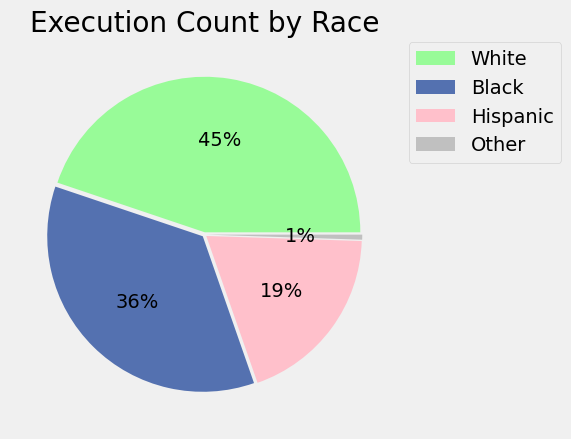

In [27]:
# Remove white space from race column
death_row['race'] = death_row.race.str.strip()
# Define colors for pie chart
colors = ['palegreen', '#5471B0','pink','silver']
# Define data for pie chart
data = death_row['race'].value_counts()
# Create pie chart
ax = data.plot(kind='pie',
               autopct='%1.0f%%', 
               explode=[0.015, 0.015, 0.015, 0.015], 
               colors=colors, 
               legend=True, 
               ylabel='',
               labeldistance=None,
               title='Execution Count by Race')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Above we see the percentage of executions by the inmate's race. White makes up the largest population with 45%. Not too far behind is Black with 36% and then Hispanic with 19%. Looking at the racial breakdown of the entire state of Texas between 1980 and 2022: 
* White people made up anywhere between 40-65% of the population (it was higher the 80s and has decreased over the years)
* Black people have made up around 11-12% 
* Hispanic people 20-40% (it was lower in the 80s and has increased over the years)  

Sources: [link]('https://www.census.gov/quickfacts/TX'), [link]('https://worldpopulationreview.com/states/texas-population'), [link]('https://demographics.texas.gov/Resources/Presentations/OSD/2017/2017_09_14_DepartmentofSavingsandMortgageLending.pdf')

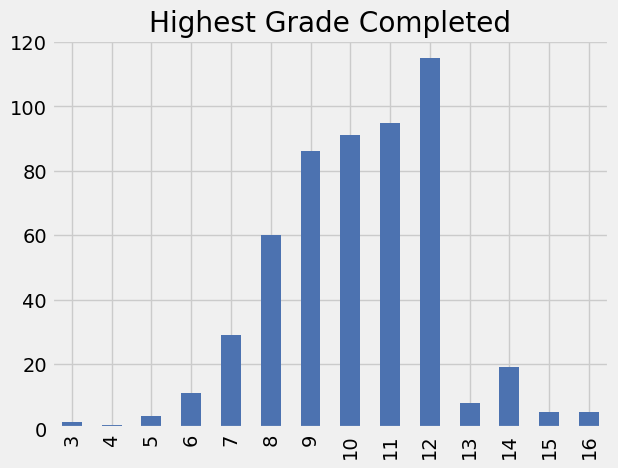

In [28]:
# Create bar chart
(death_row['years_of_education'].value_counts()
                                .sort_index()
                                .plot
                                .bar(title='Highest Grade Completed')
)
plt.show()

Years of Education represents the highest grade completed by the inmate. We see that 12 was the most common for years of education, indicating that they finished high school. And between 9 and 11 following that. A small amount completed some college. Below we'll look at additional stats on <code>years_of_education</code>.

In [29]:
death_row['years_of_education'].describe()

count    531.000000
mean      10.193974
std        2.043407
min        3.000000
25%        9.000000
50%       10.000000
75%       12.000000
max       16.000000
Name: years_of_education, dtype: float64

In [30]:
college = round(100 * death_row.years_of_education.gt(12).sum()/death_row.shape[0],1)
non_hs_grad = round(100 * death_row.years_of_education.lt(12).sum()/death_row.shape[0],1)
hs_grad = round(100 * death_row.years_of_education.eq(12).sum()/death_row.shape[0],1)
non_hs = round(100 * death_row.years_of_education.lt(9).sum()/death_row.shape[0],1)
print(f'{b}Some College:{e} {college}%')
print(f'{b}HS Grad:{e} {hs_grad}%')
print(f'{b}Did not finish HS:{e} {non_hs_grad}%')
print(f'{b}8th Grade or Lower:{e} {non_hs}%')

Some College: 6.4%
HS Grad: 19.8%
Did not finish HS: 65.3%
8th Grade or Lower: 18.4%


The above 2 cells provide a bit more information about the <code>years_of_education</code> column. On average, the inmates highest grade level was 10. About 65% of inmates did not finish high school, with 20% of the total not even making it to high school.

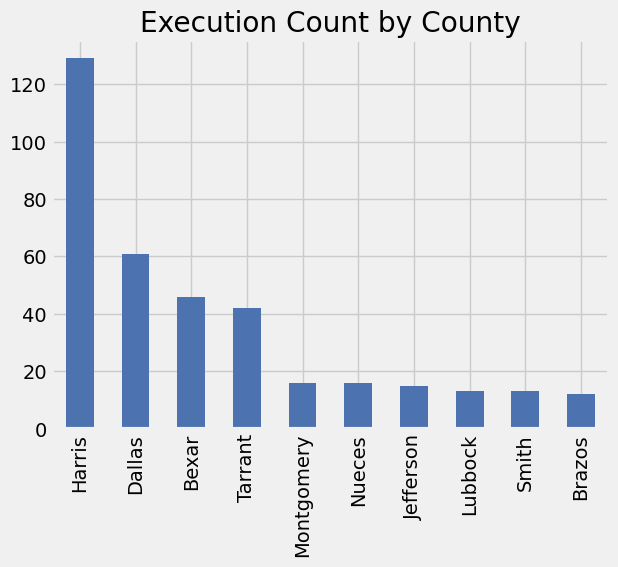

In [31]:
# Create bar chart
(death_row['county'].value_counts()
                    .head(10)
                    .plot
                    .bar(title='Execution Count by County')
)
plt.show()

The bar chart above shows the top 10 counties with the highest execution count. Harris County is first with over 120 executions, making up over 20% of the total executions in Texas. There's quite a big drop to the next highest, Dallas County, with around 60 executions. The top 4 counties make up nearly half of all the executions in Texas (there are 254 counties in Texas). 

Harris County is the largest county in Texas making up roughly 16% of the population. The largest city in Harris County is Houston. Additional research on Harris County identifies it as the death penalty capital of the world. Since 1976, the county has executed more inmates than every individual state in the union (besides Texas obviously).

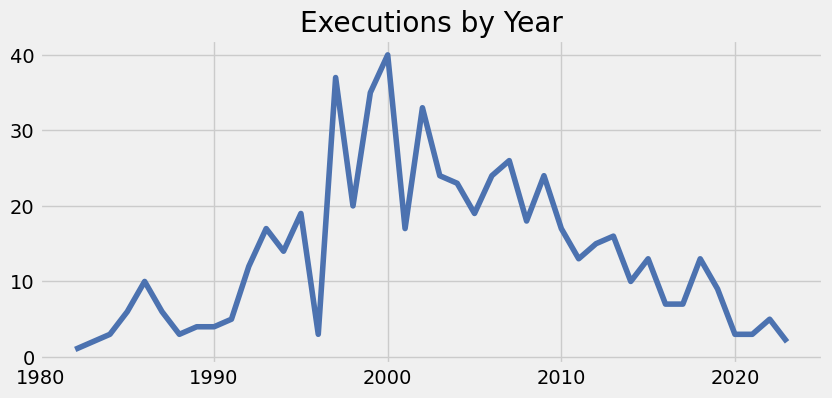

In [32]:
# Create line chart
(death_row['execution_year'].value_counts()
                            .sort_index()
                            .plot
                            .line(figsize=(9, 4),
                                  title='Executions by Year')
)
plt.show()

The line plot above shows the number of executions by year. We don't see anything above 10 executions in a year until the early 90s. All of the peak years fall between the late 90s to early 2000s with between 30 and 40 executions per year. From there, the execution count sees mild fluctuations as it continues to decrease.

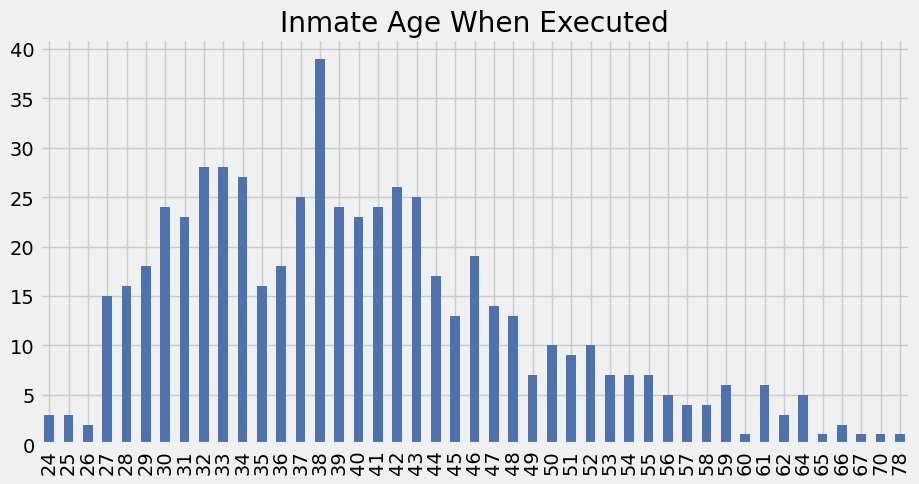

In [33]:
# Create bar chart
(death_row['age_executed'].value_counts()
                          .sort_index()
                          .plot
                          .bar(figsize=(10, 5), 
                               title='Inmate Age When Executed')
)
plt.show()

In [34]:
# Calculating mean
mean_age_ex = round(death_row.age_executed.mean())
print(f'{b}Average Age:{e} {mean_age_ex}')

Average Age: 40


There is a wide range of ages at which inmates have been executed, ranging from 24 all the way to 78. The large majority fall within the 30 to 44 age range with 38 being the most common and the average age being 40. There were 39 inmates executed at the age of 38, the next highest being age 32 or 33 both with 28 executions. Let's break it down by decade below.

In [35]:
round(death_row.age_executed.value_counts(bins = [20,30,40,50,60,70,80], sort= False, normalize=True) * 100, 2)

(19.999, 30.0]    13.97
(30.0, 40.0]      43.28
(40.0, 50.0]      28.97
(50.0, 60.0]      10.34
(60.0, 70.0]       3.28
(70.0, 80.0]       0.17
Name: age_executed, dtype: float64

Above we see the percentage of execution by decade (inmates in their 20s, 30s, 40s, etc). 43% of inmates were executed in the 30s, followed by 29% in their 40s. That's over 70% of executions falling between the ages of 30 and 49. We see just 3.5% of inmates executed over 60 years old.

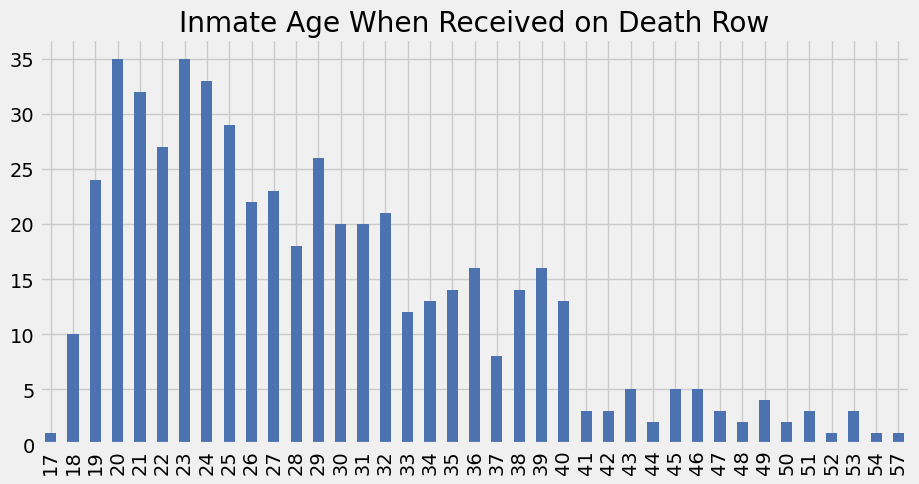

In [36]:
# Create bar chart
(death_row['age_received'].value_counts()
                          .sort_index()
                          .plot
                          .bar(figsize=(10, 5), 
                               title='Inmate Age When Received on Death Row')
)
plt.show()

The above chart represents the age when the inmate first got on death row. The time when they get on death row compared to when they did the crime can vary. It's possible that it could be 2-3 years after they commit the crime or it could be months.  

It looks like it is most common for someone to get on death row in their 20s. As the age increases, the number of inmates received on death row decreases. After the age of 32, there is a small drop off, and then after the age of 40, there is a pretty large drop off and it stays low until we reach the max age received which is 57. 

In [37]:
gt_40 = round(100 * death_row.age_received.gt(40).sum()/death_row.shape[0],1)
_19_25 = round(100 * (death_row.age_received.gt(18) & death_row.age_received.lt(26)).sum()/death_row.shape[0],1)
print(f'{b}Age Received:{e}')
print(f'Over 40: {gt_40}%')
print(f'19 to 25: {_19_25}%')

Age Received:
Over 40: 7.4%
19 to 25: 37.1%


Just 7.4% of inmates received on death row are over 40 years old while 37% are between 19 and 25 years old.

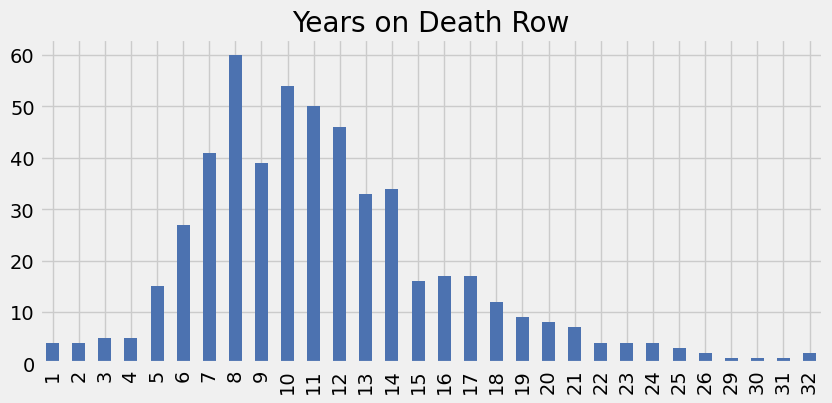

In [38]:
# Create bar chart
(death_row['years_on_dr'].value_counts()
                         .sort_index()
                         .plot
                         .bar(figsize=(9, 4),
                              title='Years on Death Row')
)
plt.show()

In [39]:
years = round(death_row.years_on_dr.mean())
print(f'{b}Average Years on DR:{e} {years}')

Average Years on DR: 11


Now, we look at the number of years the inmates spent on death row before being executed. Some inmates spent as little as 1-3 years where others spent 30-32 years. On average, inmates spend a little over a decade in prison prior to their execution. Let's see how the years spent on death row has changed over time. 

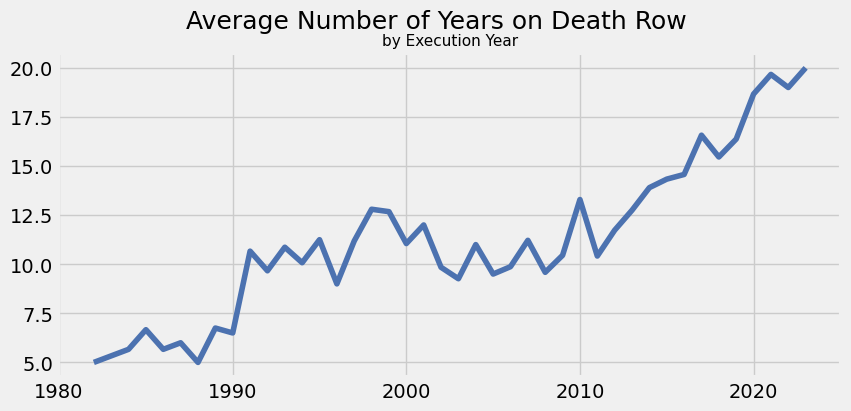

In [40]:
# Calculate average years on death row grouped by execution_year
yrs_dr_by_exec_yr = death_row.groupby('execution_year')['years_on_dr'].mean()
# Create line chart
(yrs_dr_by_exec_yr.plot.line(figsize=(9, 4),
                             xlabel=''
                            )
                        
)
# Add title / subtitle
plt.suptitle('Average Number of Years on Death Row', y=.99, fontsize=18)
plt.title('by Execution Year', fontsize=11)
plt.show()

There has been an increase in the amount of time an inmate has spent on death row overtime. The years nearly double comparing the 80s to the 90s. From the 90s to 2013, the years fluctuate between 9 and 12. However, around 2014 the increase becomes more drastic where the average time on death row increases by about 1 year each year.

# Text Analysis
Prior to execution, the inmate is given an opportunity to give their last statement. In general, the people who can be present at the time of execution is relatives of the victim and relatives of the prisoner. We'll look to do text analysis on the last statements of the inmates. 
### Last Statement Declined 
We'll start by replacing values where the inmate did not give a last statement with an empty string.

In [41]:
# Check unique values in last_statement column. 
death_row['last_statement'].value_counts().head()

None                                                                                                                                                                                                                                                                                                                                         105
This inmate declined to make a last statement.                                                                                                                                                                                                                                                                                                 3
This inmate declined to make a last statement.                                                                                                                                                                                                                                                                                        

In [42]:
no_last_statement = ['None', 
                     'This inmate declined to make a last statement.',
                     'This inmate declined to make a last statement.  ',
                     'No statement given.',
                     'No last statement given.',
                     ' No statement was made.',
                     'No, I have no final statement.', 
                     'No last statement.']

# How many inmates did not give last statement
count = len(death_row[death_row['last_statement'].isin(no_last_statement)])
percentage = count/death_row.shape[0] * 100
print(f'{b}Declined Last Statement{e}: {count} ({percentage}%)')

# Replace values with empty string
death_row['last_statement'] = death_row['last_statement'].replace(no_last_statement, '')

Declined Last Statement: 116 (20.0%)


### Remove Stop Words
Next, we want to remove the *stop words* from the last statement. Stop words are words that are insignificant (examples: "the", "there", "I", "them"), therefore we will filter them out because they don't tell us much about the statement. In the next cell, we read in a text file of roughly 1k stop words. Then we create a function that will take in a text string and output the string with all the stop words removed. We use this to create a new column in our dataframe called <code>reduced_statement</code>.

In [43]:
# Read in stop words from text file
with open('stopwords.txt', 'r') as f:
    # Create list of stop words
    for line in f:
        stop_words = line.split() 
        
def reduce_text(text):
    # Clean text - remove punctuation and convert to lower case
    text = text.lower().replace('’','')
    remove_punctuation = re.sub('[^a-zA-Z]', ' ', text)
    # Split string into list
    split_text = remove_punctuation.split()
    # Loop through list add non stop words to new string
    cleaned_string = ''
    for word in split_text:
        if word not in stop_words:
            cleaned_string += word + ' '
    
    return cleaned_string
# Create new column by applying the above function
death_row['reduced_statement'] = death_row['last_statement'].apply(reduce_text)

## Common Words
We now have a new column for the inmates last statement with the stop words removed. Let's take a look at the most common words below.

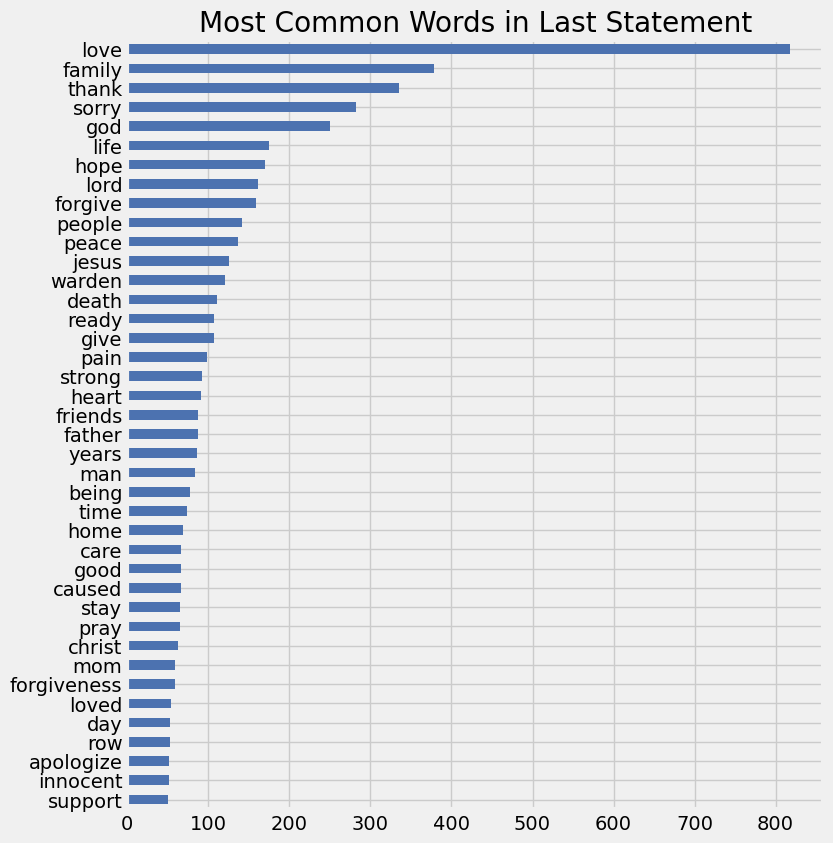

In [44]:
# Count words - save 40 most common words to variable
most_common = Counter(" ".join(death_row['reduced_statement']).split()).most_common(40)
# Create dataframe for word count
word_freq = pd.DataFrame(most_common,
                         columns=['words', 'count']
                        )
# Plot most common words
(word_freq.sort_values(by='count').plot
                                  .barh(x='words', 
                                        y='count',
                                        figsize=(8,9.5),
                                        xlabel='',
                                        legend=False,
                                        title='Most Common Words in Last Statement')
)
plt.show()

The above chart shows the 40 most common words inmates used in their last statements. "Love" was used the most by far - appearing over 800 times. There are some other common themes, such as mentions of family/friends and religious mentions "god", "jesus", "lord". Some others that stand out are: "sorry", "forgive", "innocent". 

Below we visualize a wider range of words in a word cloud.

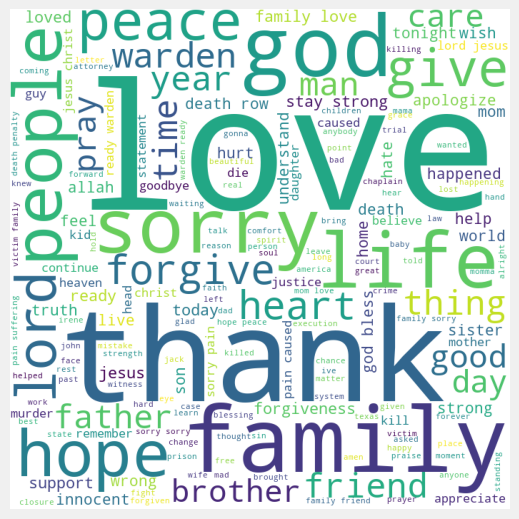

In [45]:
# Add all words from reduced_statement to single string
last_statement_words = ''
for statement in death_row['reduced_statement']:
    statement_split = statement.split()
    last_statement_words += ' '.join(statement_split)+' '
# Create word cloud
wordcloud = (WordCloud(width = 700, 
                      height = 700, 
                      background_color ='white', 
                      min_font_size = 10)
                      .generate(last_statement_words)
            )
  
# Plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

The size of the word in the word cloud represents popularity - the larger a word is, the more common it was. 
## Bigrams
Next, we look at the most common 2 words combinations (bigrams). These are words that appeared consecutively in the string. The steps taken in the next cell:
* Define <code>bigram</code> variable i.e. number of words we're looking for in combination
* Find bigrams from the string <code>last_statement_words</code> we created above
* Count bigrams and convert to dictionary (bigram=key, count=value)
* Create new dictionary sorted by count
* Print most common bigrams

In [46]:
bigram = 2
bigrams = ngrams(last_statement_words.split(), bigram)
bigram_dict = dict(Counter(bigrams))
sorted_dict = dict(sorted(bigram_dict.items(), 
                          key=lambda item: item[1], 
                          reverse=True)
                  )
# Print bigrams that appear more than 10 times
for n in sorted_dict:
    if sorted_dict[n] >= 10:
        print(n, sorted_dict[n])

('family', 'love') 56
('love', 'love') 53
('stay', 'strong') 52
('god', 'bless') 41
('death', 'row') 41
('love', 'thank') 36
('jesus', 'christ') 33
('lord', 'jesus') 32
('pain', 'caused') 32
('sorry', 'pain') 29
('ready', 'warden') 28
('family', 'friends') 27
('love', 'family') 27
('family', 'sorry') 26
('thank', 'being') 25
('sorry', 'sorry') 23
('hope', 'peace') 22
('thank', 'love') 20
('victim', 'family') 20
('thank', 'lord') 18
('thank', 'god') 17
('mom', 'love') 17
('thank', 'family') 16
('pain', 'suffering') 16
('love', 'ready') 16
('love', 'god') 16
('love', 'care') 16
('give', 'love') 15
('love', 'warden') 15
('death', 'penalty') 15
('love', 'stay') 15
('warden', 'ready') 14
('thank', 'warden') 14
('love', 'mom') 14
('hope', 'forgive') 14
('innocent', 'man') 14
('holy', 'holy') 14
('friends', 'love') 13
('love', 'sorry') 13
('caused', 'family') 12
('love', 'support') 12
('friends', 'family') 12
('god', 'forgive') 12
('sorry', 'love') 12
('family', 'thank') 12
('better', 'place'

We see similar themes in the above that we did looking at the single words, including many mentions of love, family, and god. Some of the most common bigrams are: "family love", "god bless", "jesus christ", "family friends". The third most common is "stay strong". Another theme we see is a apologetic tone: "pain caused", "sorry pain", "victim family". 

One more that stands out is "innocent man". It appears there are a handful of prisoners who are still claiming innocence even in the moment before their execution. After some additional research, multiple sources report 190 death row prisoners exonerated of all charges related to the wrongful convictions that put them on death row since 1973 [(source)]('https://deathpenaltyinfo.org/policy-issues/innocence'). These exonerations include all of the US, not just Texas (16 in Texas). This raises the question of how many innocent prisoners were executed before being able to prove their innocence.  

## Trigrams
Below we look at the most common trigrams in the <code>last_statement_words</code> string. Trigrams are 3 word combinations that appear consecutively in the string. We take the same steps we did in the previous cell when counting bigrams, except this time n=3.

In [47]:
trigram = 3
# Find trigrams in last_statement_words
trigrams = ngrams(last_statement_words.split(), trigram)
# Create dictionary with count of trigrams 
trigram_dict = dict(Counter(trigrams))
# Sort dictionary
sorted_dict = dict(sorted(trigram_dict.items(), 
                          key=lambda item: item[1], 
                          reverse=True)
                  )
# Print trigrams that appear more than 5 times
for n in sorted_dict:
    if sorted_dict[n] >= 5:
        print(n, sorted_dict[n])

('sorry', 'pain', 'caused') 16
('love', 'stay', 'strong') 12
('lord', 'jesus', 'christ') 10
('love', 'love', 'love') 9
('love', 'god', 'bless') 9
('pain', 'caused', 'family') 8
('thank', 'lord', 'jesus') 8
('love', 'mom', 'love') 7
('hope', 'heart', 'forgive') 7
('god', 'bless', 'love') 7
('holy', 'holy', 'holy') 7
('hope', 'brings', 'closure') 6
('love', 'ready', 'warden') 6
('thy', 'thy', 'kingdom') 6
('thy', 'kingdom', 'thy') 6
('kingdom', 'thy', 'earth') 6
('thy', 'earth', 'heaven') 6
('earth', 'heaven', 'give') 6
('heaven', 'give', 'day') 6
('give', 'day', 'daily') 6
('day', 'daily', 'bread') 6
('daily', 'bread', 'forgive') 6
('lead', 'temptation', 'deliver') 6
('temptation', 'deliver', 'evil') 6
('love', 'warden', 'ready') 5
('thank', 'family', 'friends') 5
('family', 'friends', 'love') 5
('father', 'art', 'heaven') 5
('heaven', 'hallowed', 'thy') 5
('hallowed', 'thy', 'thy') 5
('against', 'lead', 'temptation') 5


Above we see the most common trigrams found in the last statments. The most common is "sorry pain caused" (another in the top 5 most common is "pain caused family"), most likely indicating the inmate is apologizing for the pain that they have caused the victim's family. Nearly half of the most common trigrams are religious, mentioning "god, "jesus", or parts of a prayer. Something else that stands out is, "hope bring closure". We can speculate that the prisoner is hoping their execution brings the victim's family closure.

# Conclusion
This wraps up the exploration and analysis of Death Row Information in Texas. This was a very eye opening project and offered a lot of insight into Death Row and the prisoners who occupy it. 

Some of my takeaways from this project:
* There is a disproportionate amount of black people executed considering the racial breakdown of the entire population: 11-12% of total population, 36% of executions.
* It is common for prisoners on death row to have a low education level - 65% did not complete high school.
* Harris county (TX) has executed more inmates than every individual state in the union.
* The number of executions per year has been decreasing over the last 20 years.
* 43% of executions happen between age 30 and 39, only 14% of executions happen after age 50.
* 37% of prisoners were ages 19-25 when received on death row. 
* Prisoners spend about a decade on death row on average.
* The average time on death row has nearly quadrupuled since 1982.
* The mass majority of inmates last statements are uplifting. In general, common themes of the messages are thankful, loving, apologetic, religous.